In [398]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as sps

Скачайте этот набор данных кредитных рисков. Выполните исследовательский анализ (EDA) для набора данных, включая описательную статистику и визуализации. Опишите результаты.

In [399]:
raw_dataset = pd.read_csv ('../../../../../DANIT/Credit Risk.csv')
raw_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [400]:
# Оценка имеющихся данных
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Первый вывод: база состоит из 614 записей, из которых полностью внесены лишь поля "образование", "доход", "доход сополучателя", "локация собственности", "статус кредита".

Оценим, какой разброс значений по колонкам, и могут быть полезными или нет.

In [401]:
raw_dataset.Property_Area.value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [402]:
raw_dataset.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [403]:
raw_dataset.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [404]:
raw_dataset.Education.value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [405]:
raw_dataset.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [406]:
raw_dataset.LoanAmount.value_counts()

120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: LoanAmount, Length: 203, dtype: int64

In [407]:
raw_dataset.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Анализ данных позволяет говорить о наличии ряда несвязанных параметров, не существует логических зависимостей между ними для подмены отсутствующих показателей NA. Поэтому как вариант я принимаю решению просто убрать такие данные, учитывая их малую долю в общем количестве данных

In [408]:
dataset = raw_dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 1 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            480 non-null    object 
 1   Gender             480 non-null    object 
 2   Married            480 non-null    object 
 3   Dependents         480 non-null    object 
 4   Education          480 non-null    object 
 5   Self_Employed      480 non-null    object 
 6   ApplicantIncome    480 non-null    int64  
 7   CoapplicantIncome  480 non-null    float64
 8   LoanAmount         480 non-null    float64
 9   Loan_Amount_Term   480 non-null    float64
 10  Credit_History     480 non-null    float64
 11  Property_Area      480 non-null    object 
 12  Loan_Status        480 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 52.5+ KB


Для определения зависимостей добавим несколько расчетных колонок, и поменяем форматы данных, т.к. очевидно, что Доходы учитываются за год, а суму кредита (которая очевидно указана в тысячах) нужно разделить на продолжительность, которая в свою очередь указана в месячном исчислении. Добавим новые колонки Годовой общий доход (включая Коапликанта), Сума кредита за год.
Также посчитаем их соотношение. (debt service cover)

In [409]:
pd.options.mode.chained_assignment = None

dataset['total_income'] = (dataset.ApplicantIncome + dataset.CoapplicantIncome).astype('float64')
dataset['annual_loan'] = (dataset.LoanAmount *1000 / dataset.Loan_Amount_Term*12).astype('float64')
dataset['debt_service_cover'] = (dataset.total_income / dataset.annual_loan).astype('float64')
dataset['Credit_history_in_place'] = dataset['Credit_History'].replace([1.0, 0],['Y', 'N'])
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,total_income,annual_loan,debt_service_cover,Credit_history_in_place
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,4266.666667,1.427578,Y
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,2200.000000,1.363636,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,4000.000000,1.235250,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,4700.000000,1.276596,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,8900.000000,1.080112,Y


In [410]:
dataset.Credit_history_in_place.value_counts()

Y    410
N     70
Name: Credit_history_in_place, dtype: int64

После первичной обработки удаляем ненужные / дублирующиеся колонки

In [411]:
dataset = dataset.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History'], axis=1)
dataset.head()

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Property_Area,Loan_Status,total_income,annual_loan,debt_service_cover,Credit_history_in_place
1,Male,Yes,1,Graduate,No,360.0,Rural,N,6091.0,4266.666667,1.427578,Y
2,Male,Yes,0,Graduate,Yes,360.0,Urban,Y,3000.0,2200.000000,1.363636,Y
3,Male,Yes,0,Not Graduate,No,360.0,Urban,Y,4941.0,4000.000000,1.235250,Y
4,Male,No,0,Graduate,No,360.0,Urban,Y,6000.0,4700.000000,1.276596,Y
5,Male,Yes,2,Graduate,Yes,360.0,Urban,Y,9613.0,8900.000000,1.080112,Y


Изучаем полученные в итоге данные и проводим базовые визуализации

In [412]:
dataset.describe()

,Loan_Amount_Term,total_income,annual_loan,debt_service_cover
count,480.000000,480.000000,480.000000,480.000000
mean,342.050000,6945.324833,5511.208333,1.466651
std,65.212401,5969.948374,4414.166957,1.204826
min,36.000000,1442.000000,300.000000,0.067374
25%,360.000000,4148.000000,3425.000000,1.020853
50%,360.000000,5422.500000,4400.000000,1.213907
75%,360.000000,7672.500000,6166.666667,1.500393
max,480.000000,81000.000000,51666.666667,11.891000


Loan_Amount_Term


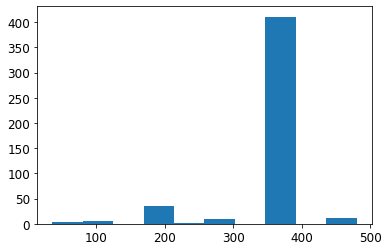

total_income


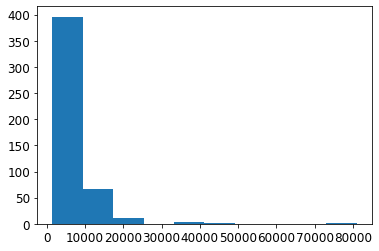

annual_loan


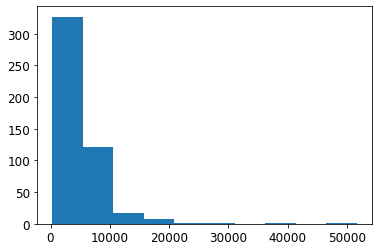

debt_service_cover


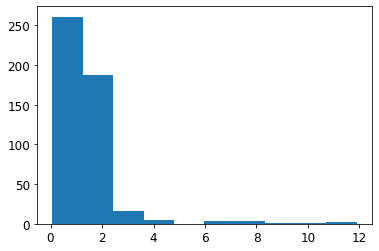

In [413]:
plt.rcParams.update({'font.size': 12})
for с in ['Loan_Amount_Term', 'total_income', 'annual_loan', 'debt_service_cover']:
    print(с)
    plt.hist(dataset[с])
    plt.show()

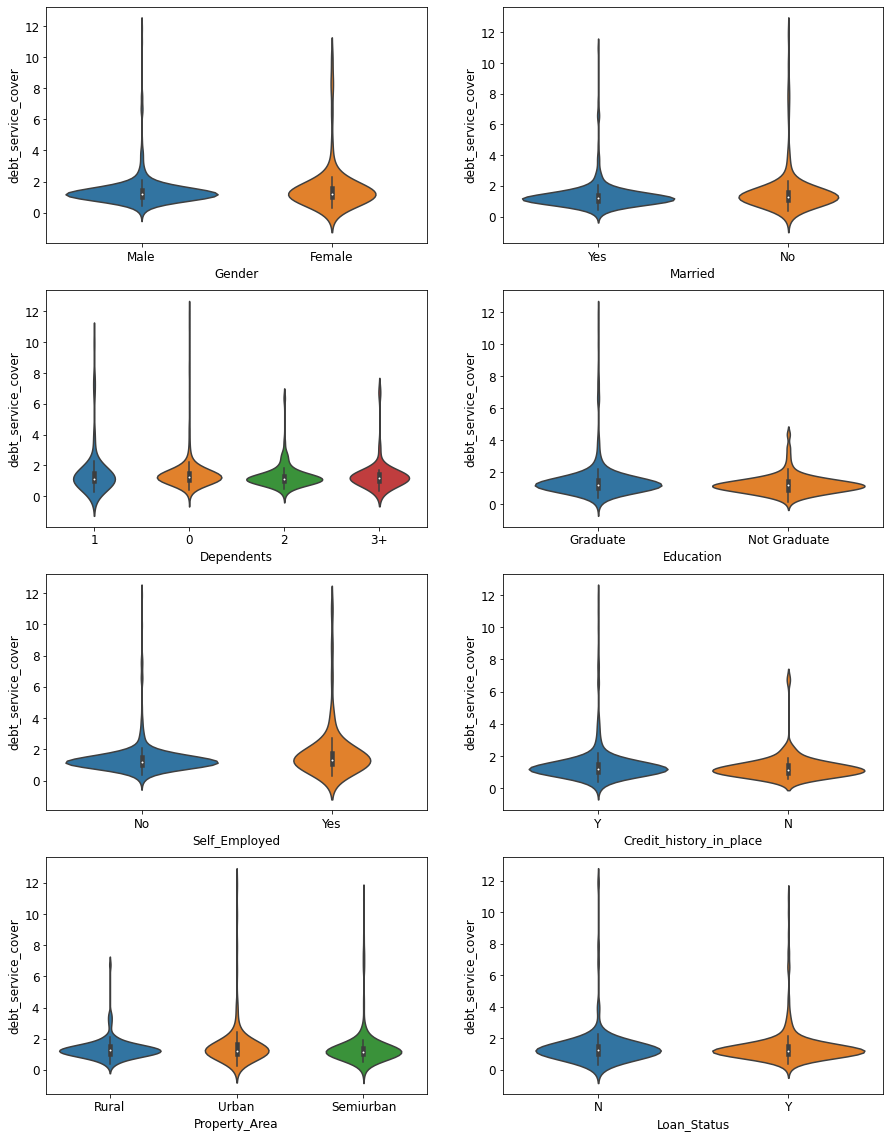

In [414]:
plt.figure(figsize=(15,20))
for i, context in enumerate(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_history_in_place', 'Property_Area', 'Loan_Status' ]):
    
    plt.subplot(4,2,i+1)
    sns.violinplot(data=dataset, y='debt_service_cover', x=context)



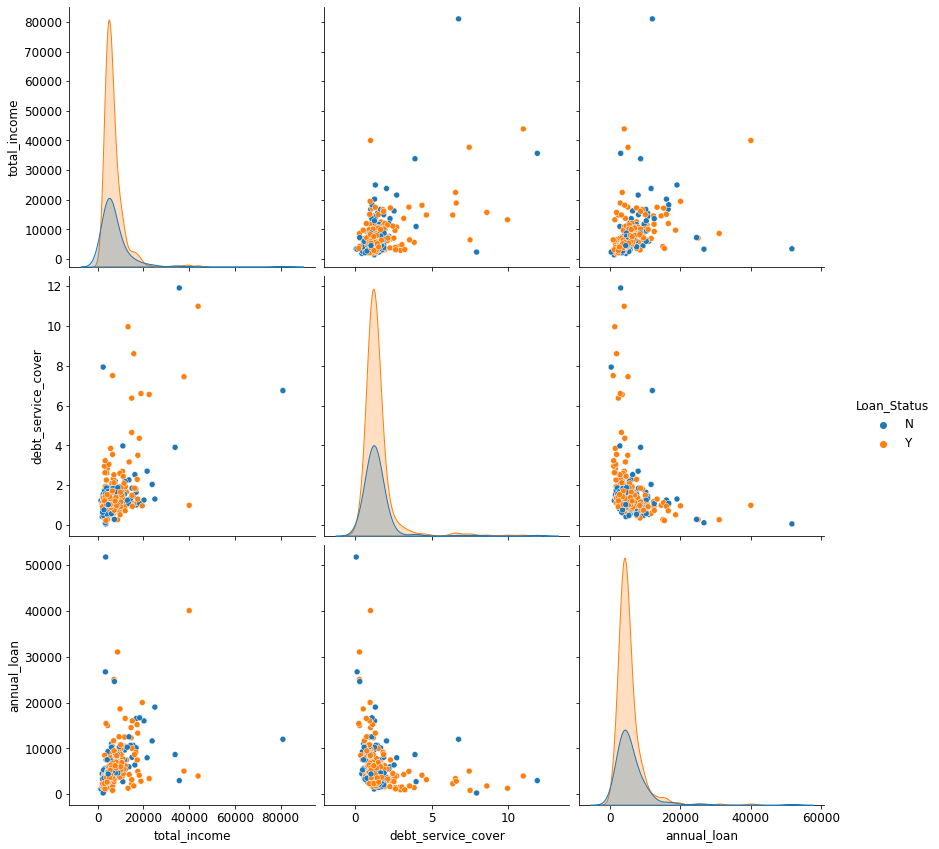

In [415]:
sns.pairplot(dataset[['total_income','debt_service_cover','annual_loan', 'Loan_Status']], hue='Loan_Status', height = 4)

Так как в наличии аномальные выбросы значений, очистим аномальные данные

In [416]:
Q1 = dataset.total_income.quantile(0.25)
Q3 = dataset.total_income.quantile(0.75)
IQR = Q3 - Q1

fence_coef = 3
dataset_2 = dataset[~((dataset.total_income.astype(float) < (Q1 - fence_coef * IQR)) | (dataset.total_income.astype(float) > (Q3 + fence_coef * IQR)))]


Q1 = dataset_2.annual_loan.quantile(0.25)
Q3 = dataset_2.annual_loan.quantile(0.75)
IQR = Q3 - Q1

fence_coef = 3
dataset_clean = dataset_2[~((dataset_2.annual_loan.astype(float) < (Q1 - fence_coef * IQR)) | (dataset_2.annual_loan.astype(float) > (Q3 + fence_coef * IQR)))]


dataset_clean.count()

Gender                     453
Married                    453
Dependents                 453
Education                  453
Self_Employed              453
Loan_Amount_Term           453
Property_Area              453
Loan_Status                453
total_income               453
annual_loan                453
debt_service_cover         453
Credit_history_in_place    453
dtype: int64

Учитывая полученные данные, начинаем моделирование модели, используя подбор переменных под параметры через метод get_dummies. Так как есть большое количество классифицируемых данных, попробуем за базовый вариант взять Decision tree regressor

In [417]:
pd.get_dummies(dataset_clean.drop('Loan_Status', axis=1), drop_first=True)

,Loan_Amount_Term,total_income,annual_loan,debt_service_cover,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Credit_history_in_place_Y
1,360.0,6091.0,4266.666667,1.427578,1,1,1,0,0,0,0,0,0,1
2,360.0,3000.0,2200.000000,1.363636,1,1,0,0,0,0,1,0,1,1
3,360.0,4941.0,4000.000000,1.235250,1,1,0,0,0,1,0,0,1,1
4,360.0,6000.0,4700.000000,1.276596,1,0,0,0,0,0,0,0,1,1
5,360.0,9613.0,8900.000000,1.080112,1,1,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,360.0,2900.0,2366.666667,1.225352,0,0,0,0,0,0,0,0,0,1
610,180.0,4106.0,2666.666667,1.539750,1,1,0,0,1,0,0,0,0,1
611,360.0,8312.0,8433.333333,0.985613,1,1,1,0,0,0,0,0,1,1
612,360.0,7583.0,6233.333333,1.216524,1,1,0,1,0,0,0,0,1,1


In [418]:
x =pd.get_dummies(dataset_clean.drop('Loan_Status', axis=1), drop_first=True)
y = pd.get_dummies(dataset_clean['Loan_Status'], drop_first=True)

In [419]:
from sklearn.model_selection import train_test_split

In [420]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)
y_test

,Y
15,1
26,1
176,1
280,0
427,1
...,...
483,1
545,1
540,1
146,1


In [421]:
from sklearn.tree import DecisionTreeClassifier
model  = DecisionTreeClassifier()
model.fit(x_train, y_train)
base_predict = model.predict(x_test)

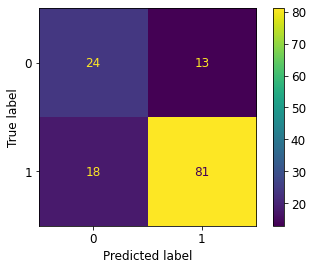

In [422]:
import sklearn.metrics as skm
skm.confusion_matrix(y_test, base_predict)
skm.plot_confusion_matrix(model, x_test, y_test)

In [423]:
print(skm.classification_report(y_test,base_predict))

              precision    recall  f1-score   support

           0       0.57      0.65      0.61        37
           1       0.86      0.82      0.84        99

    accuracy                           0.77       136
   macro avg       0.72      0.73      0.72       136
weighted avg       0.78      0.77      0.78       136



In [424]:
pd.DataFrame(index=x.columns,data=model.feature_importances_,columns=['Feature Importance']).sort_values("Feature Importance")

,Feature Importance
Gender_Male,0.007694
Property_Area_Urban,0.007834
Self_Employed_Yes,0.009344
Dependents_2,0.009792
Married_Yes,0.013421
Education_Not Graduate,0.013499
Dependents_3+,0.016087
Dependents_1,0.027327
Loan_Amount_Term,0.037869
Property_Area_Semiurban,0.040854


In [425]:
from sklearn.tree import plot_tree

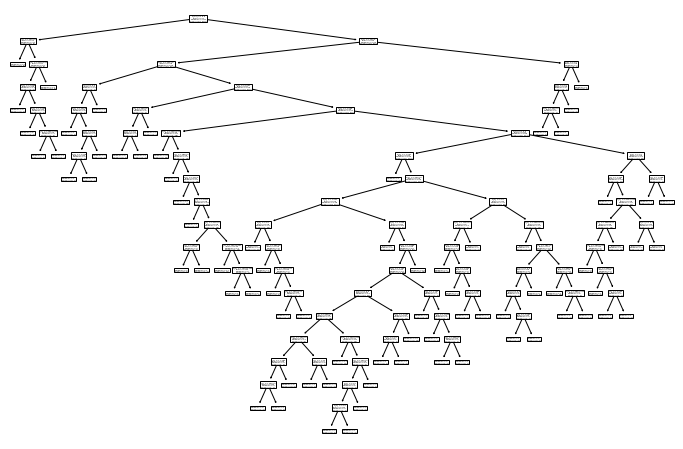

In [426]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,8))
plot_tree(model);

Как видим, базовая точность не очень высокая плюс из всех параметров многие влияют на результат на уровне стат. погрешности: пол, самозанятость, наличие детей и т.д. Наиболее точно результат предсказывают параметры кредита, доходы и наличие кредитной истории.
Воспользуемся параметризацией для поиска оптимально настроенной модели.

In [427]:
def report_model(model):
    model_preds = model.predict(x_test)
    print(skm.classification_report(y_test,model_preds))
    print('\n')
    plt.figure(figsize=(15,10),dpi=150)
    plot_tree(model,filled=True,feature_names=x.columns);

Очевидно лучший результат дает ограничение глубины 5 уровнем

In [428]:
pruned_tree = DecisionTreeClassifier(max_depth=5)
pruned_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5)

              precision    recall  f1-score   support

           0       0.95      0.49      0.64        37
           1       0.84      0.99      0.91        99

    accuracy                           0.85       136
   macro avg       0.89      0.74      0.78       136
weighted avg       0.87      0.85      0.84       136





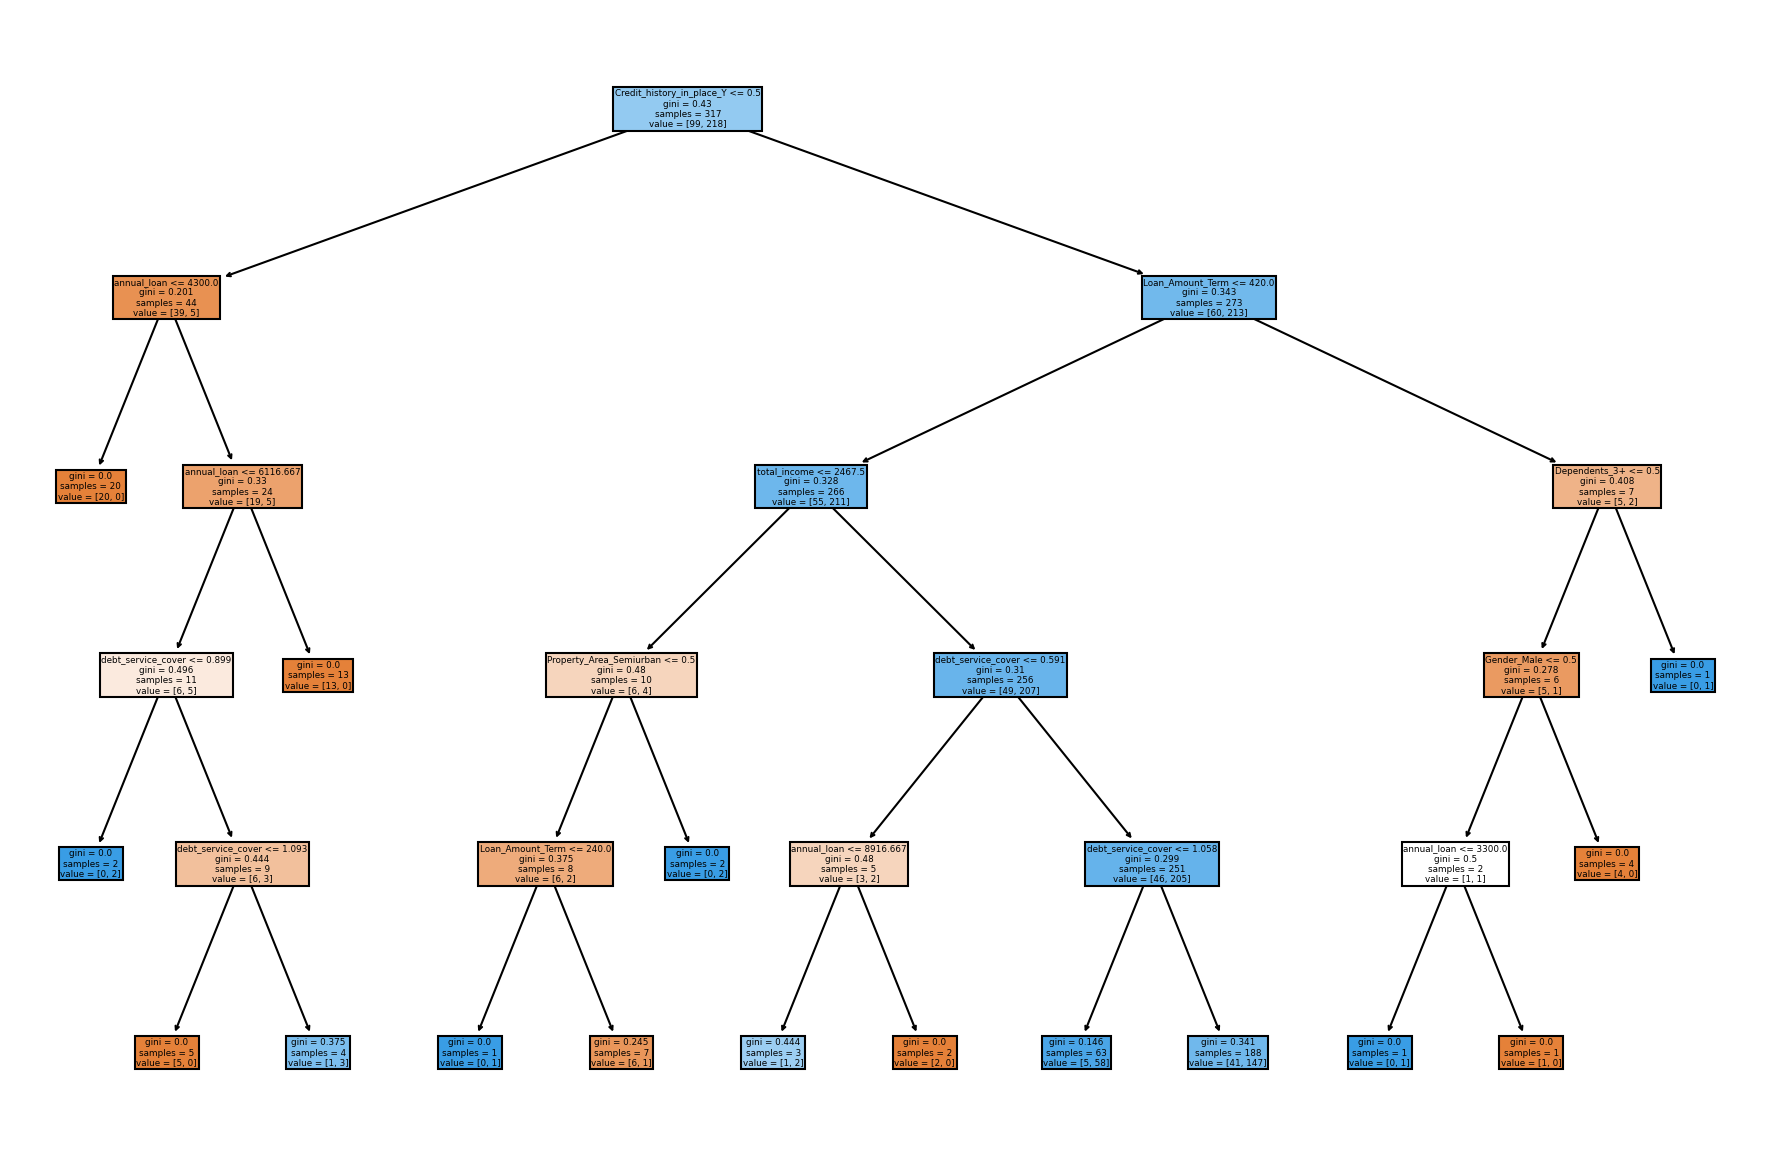

In [429]:
report_model(pruned_tree)

8 листьев на ноде тоже дает хорошую точность

In [430]:
pruned_tree = DecisionTreeClassifier(max_leaf_nodes=8)
pruned_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=8)

              precision    recall  f1-score   support

           0       0.86      0.65      0.74        37
           1       0.88      0.96      0.92        99

    accuracy                           0.88       136
   macro avg       0.87      0.80      0.83       136
weighted avg       0.87      0.88      0.87       136





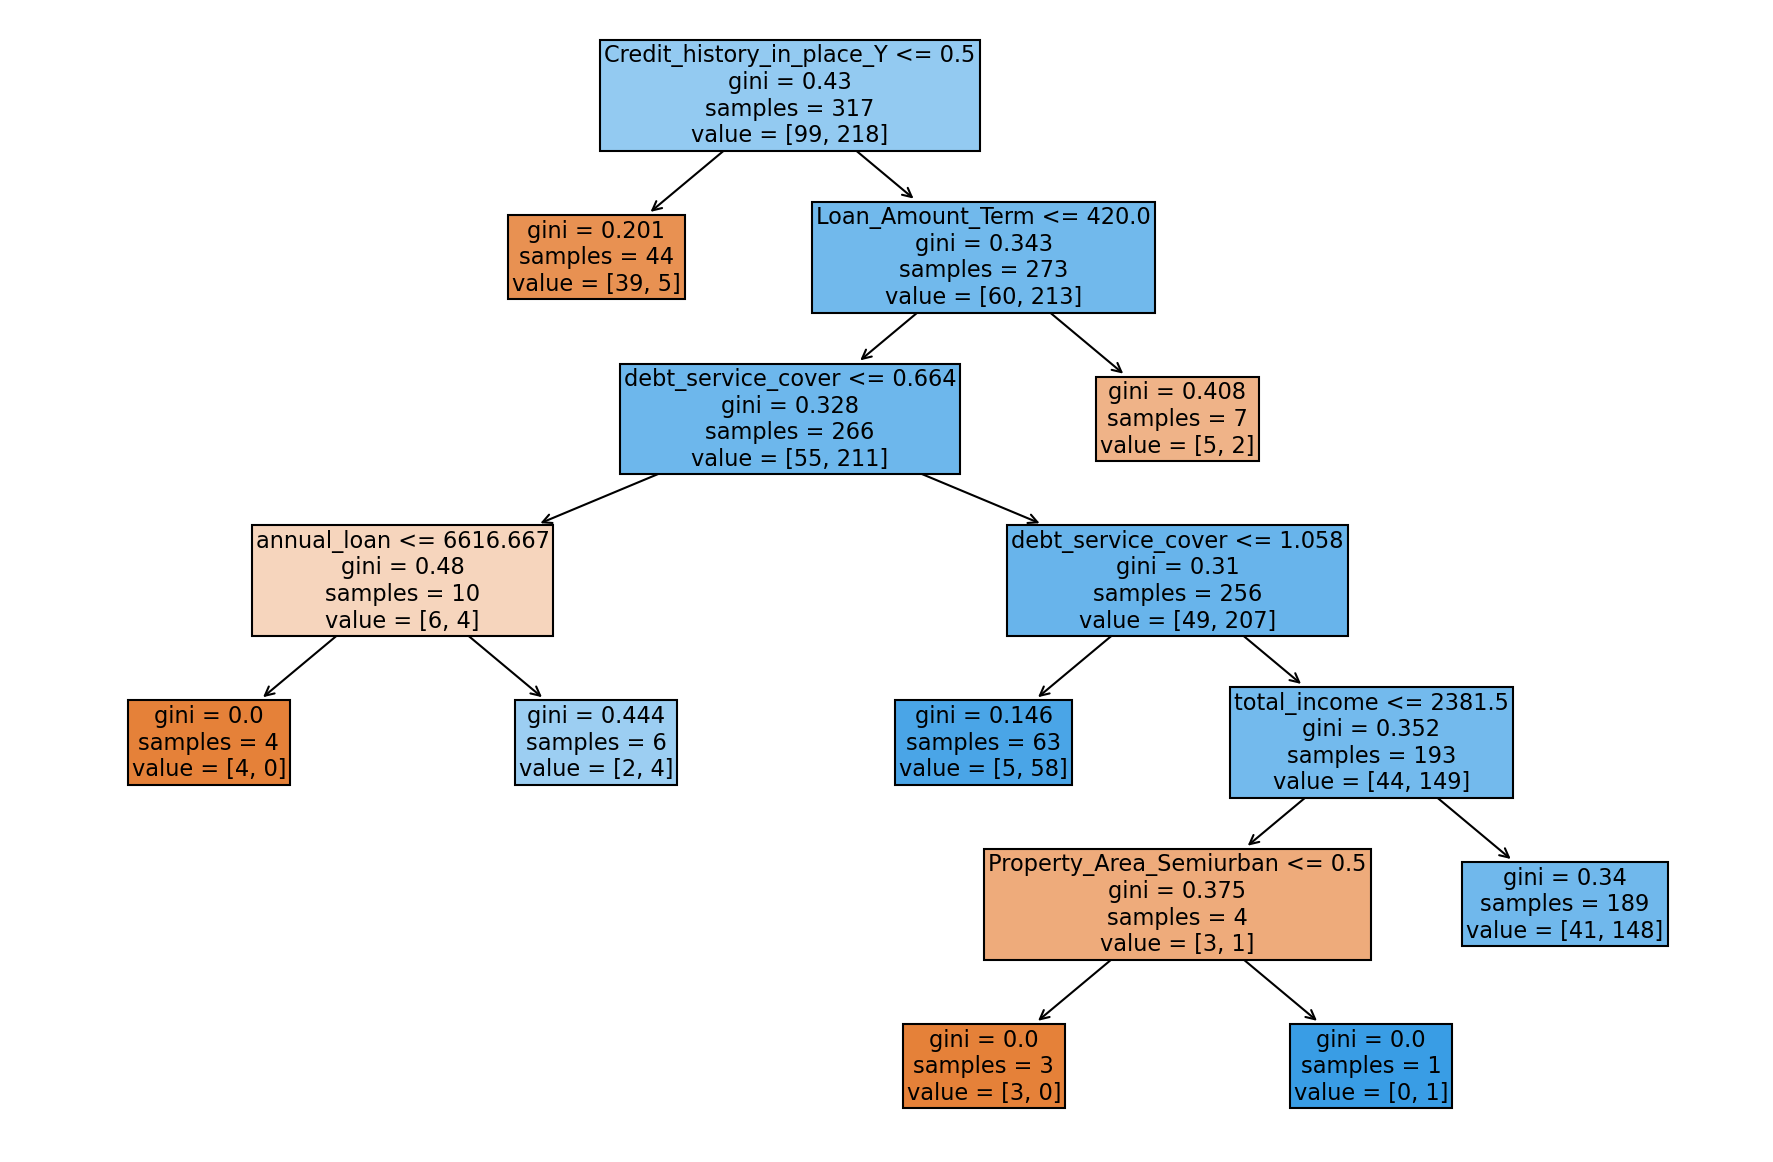

In [431]:
report_model(pruned_tree)

А с критерием энтропии точность остается низкой

In [432]:
entropy_tree = DecisionTreeClassifier(criterion='entropy')
entropy_tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

              precision    recall  f1-score   support

           0       0.57      0.65      0.61        37
           1       0.86      0.82      0.84        99

    accuracy                           0.77       136
   macro avg       0.72      0.73      0.72       136
weighted avg       0.78      0.77      0.78       136





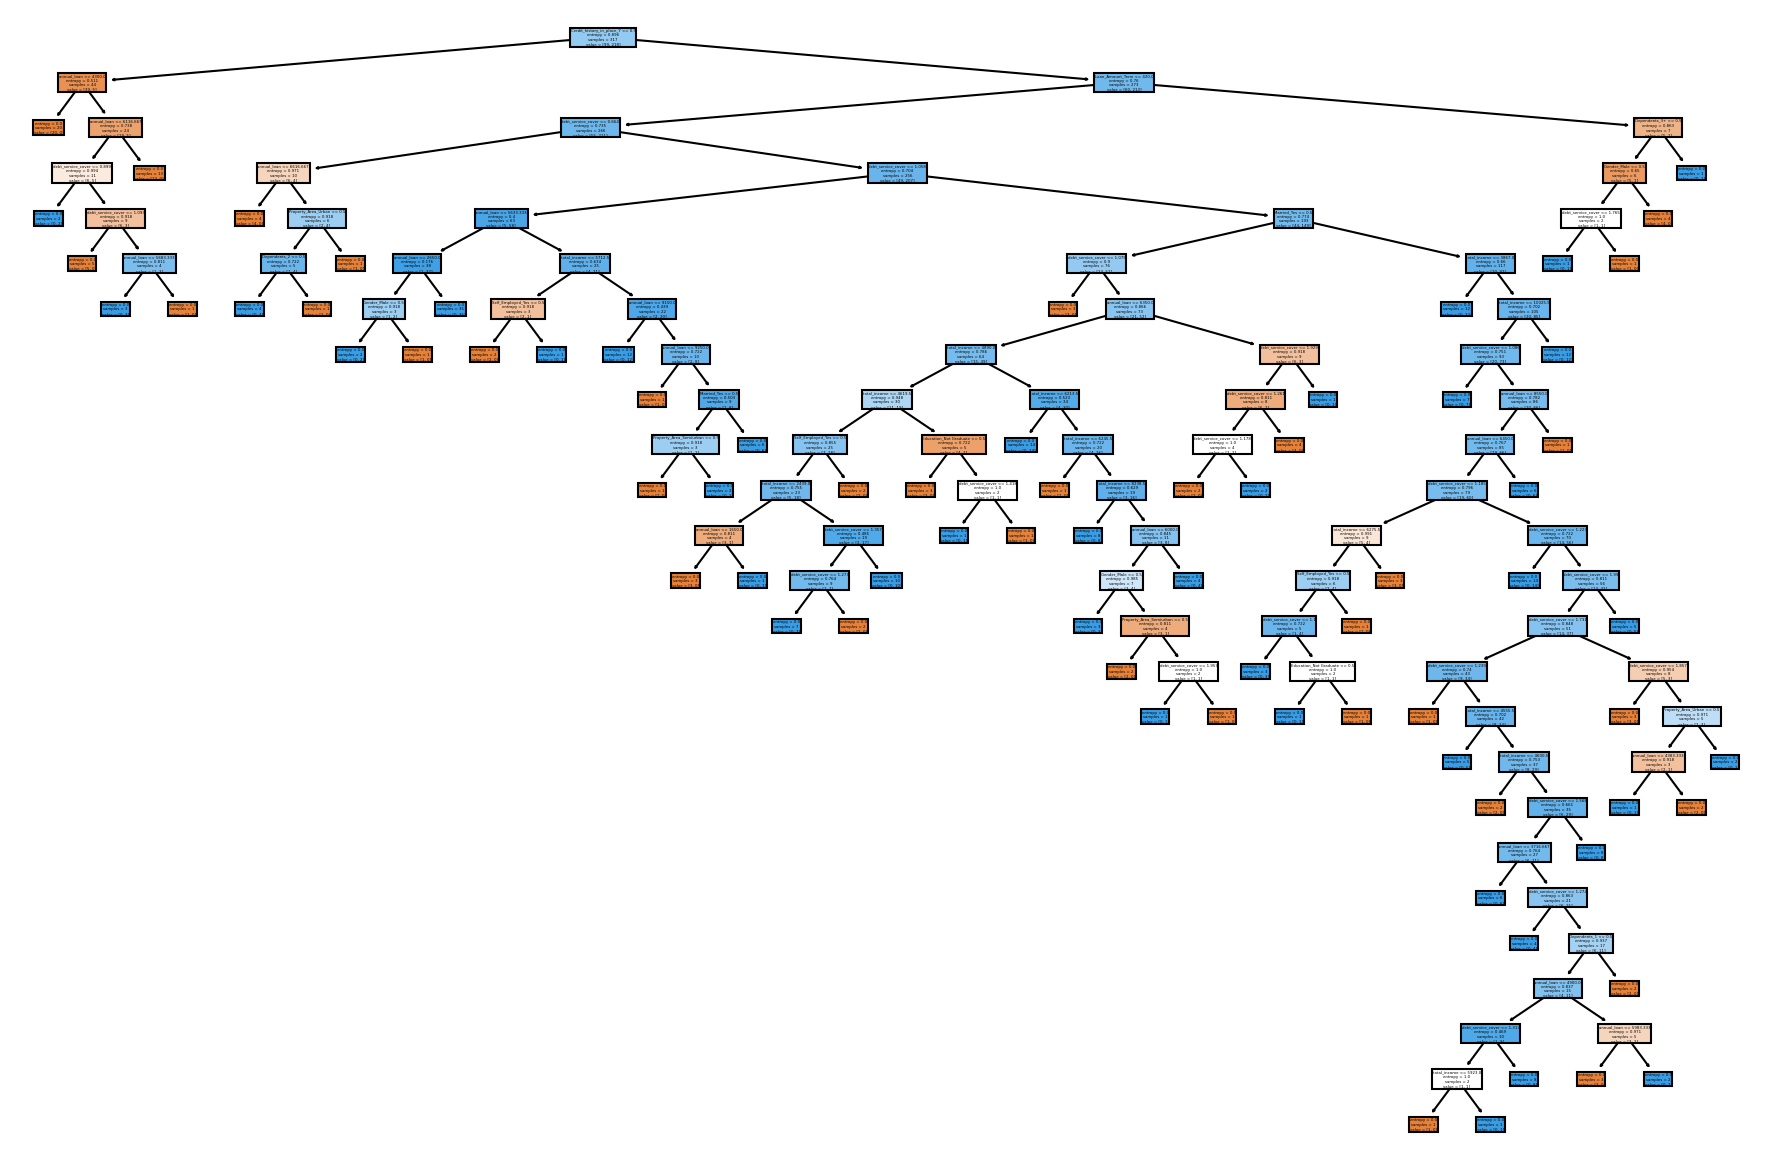

In [433]:
report_model(entropy_tree)

Создадим также метод поиска других подходящих регрессоров, протестируем лучший из них также на точность предсказания:

In [434]:
dataset_clean_dumm = pd.get_dummies(dataset_clean, drop_first=True)

dataset_clean_dumm.columns

Index(['Loan_Amount_Term', 'total_income', 'annual_loan', 'debt_service_cover',
       'Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2',
       'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y',
       'Credit_history_in_place_Y'],
      dtype='object')

In [435]:
import numpy as np
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

def getBestRegressor(X, Y):
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
    models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]

    TestModels = pd.DataFrame()
    res = {}
    tmp = {}
    #для каждой модели из списка
    for model in models:
        #получаем имя модели
        m = str(model)
        # print (m)
        tmp['Model'] = m[:m.index('(')]    
        #обучаем модель
        model.fit(X_train, Y_train) 
        #вычисляем R^2 - коэффициент детерминации
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        #вычисляем MAE - средний модуль отклонения 
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        #вычисляем RMSE - корень из среднего квадрата отклонения
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model.predict(X_test), Y_test)))

        #записываем данные и итоговый DataFrame
        TestModels = TestModels.append([tmp])
    #делаем индекс по названию модели
    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res

In [436]:
X1 = dataset_clean_dumm[['Loan_Amount_Term', 'total_income', 'annual_loan', 'debt_service_cover',
       'Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2',
       'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban',
       'Credit_history_in_place_Y']]
Y1 = dataset_clean_dumm['Loan_Status_Y']

test1 = getBestRegressor(X1, Y1)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RidgeCV,0.19374,0.30340,0.41443
LinearRegression,0.19220,0.30149,0.41482
LassoCV,0.15407,0.36820,0.42450
RandomForestRegressor,0.13122,0.30967,0.43019
GradientBoostingRegressor,0.07765,0.31874,0.44326
DecisionTreeRegressor,-0.23652,0.30905,0.51322
KNeighborsRegressor,-0.03940,0.41896,0.47054


In [437]:
from sklearn.linear_model import Ridge
model2 = Ridge()
model2.fit(x_train,y_train)
y_pred = model2.predict(x_test)
pred = pd.DataFrame(np.rint(y_pred), dtype = int)

In [438]:
print(skm.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73        37
           1       0.87      0.99      0.92        99

    accuracy                           0.88       136
   macro avg       0.91      0.79      0.83       136
weighted avg       0.89      0.88      0.87       136



Вывод, как и Decision Tree (max depth 5), Ridge model тоже неплохо справляется с прогнозированием данных